# **Vision Transformer with CIFAR-10 — 패치 임베딩부터 분류까지**

**Vision Transformer(ViT)** 실습을 목표로 합니다.  
CNN과 달리 ViT는 이미지를 **패치(patch) 시퀀스**로 바꾼 뒤, NLP의 Transformer Encoder와 거의 같은 방식으로 처리합니다.

## 학습 목표
- 이미지를 **패치 토큰**으로 바꾸는 과정(= Patch Embedding)을 이해한다.
- **[CLS] 토큰 + Positional Embedding** 이 왜 필요한지 설명할 수 있다.
- Transformer Encoder의 핵심 구성(**Pre-LN / MHSA / FFN / Residual**)을 코드에서 찾아 읽을 수 있다.
- 학습 후 **오분류(실패) 샘플**을 통해 모델의 한계를 분석한다.

> 권장 흐름: (1) 데이터/전처리 → (2) ViT 구성 → (3) 학습/평가 → (4) 오분류 분석


---
## 0) Setup (환경 준비)

- **목적:** 실습에 필요한 패키지를 로드하고, 재현 가능한 실험을 위해 시드를 고정합니다.
- **관찰 포인트**
  - 실습에 필요한 유틸 패키지(`einops`, `torchinfo` 등) 준비
  - GPU 사용 여부(`cuda`) 확인

In [1]:
import importlib.util
import subprocess
import sys

def ensure_package(pkg_name: str, import_name=None):
    """
    패키지 설치 여부를 확인하고, 설치되어 있지 않으면 설치합니다.
    """
    name = import_name or pkg_name
    # 패키지가 설치되어 있는지 확인
    if importlib.util.find_spec(name) is None:
        print(f"[install] {pkg_name} 라이브러리를 설치 중입니다... (import name: {name})")
        try:
            # -q 옵션을 추가하여 설치 과정을 간결하게 유지할 수 있습니다.
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg_name])
            print(f"[success] {pkg_name} 설치 완료.")
        except subprocess.CalledProcessError as e:
            print(f"[error] {pkg_name} 설치 실패: {e}")
    else:
        print(f"[ok] {pkg_name} 이미 설치되어 있습니다.")

# 설치가 필요한 패키지 리스트 (패키지명, 임포트명)
# 임포트명이 패키지명과 다른 경우 튜플로 지정합니다.
packages = [
    ("einops", "einops"),
    ("torchinfo", "torchinfo")
]

# 루프를 돌며 확인 및 설치
for pkg, imp in packages:
    ensure_package(pkg, imp)

[ok] einops 이미 설치되어 있습니다.
[ok] torchinfo 이미 설치되어 있습니다.


In [2]:
import torch
from torch import nn
from torch import nn, einsum
import torch.nn.functional as F  # 함수형 API(F): activation/loss 등
from torch import optim

from einops import rearrange, repeat  # ViT에서 자주 쓰는 텐서 재배열(rearrange)·복제(repeat)
from einops.layers.torch import Rearrange
import numpy as np
import torchvision  # 데이터/변환(torchvision) 사용 (CIFAR-10 포함)
import time
from torchinfo import summary

print('torch:', torch.__version__)  # torch 버전 출력
print('torchvision:', torchvision.__version__)  # torchvision 버전 출력
print('cuda available:', torch.cuda.is_available())  # GPU 사용 가능 여부
if torch.cuda.is_available():
    print('gpu:', torch.cuda.get_device_name(0))  # GPU 이름 출력

try:
    get_ipython().system('nvidia-smi -L')  # GPU 목록 확인(가능한 경우)
except Exception as e:
    print('nvidia-smi not available:', e)  # nvidia-smi가 없는 환경이면 무시

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


torch: 2.5.1
torchvision: 0.20.1+cpu
cuda available: True
gpu: NVIDIA A10-24Q
GPU 0: NVIDIA A10-24Q (UUID: GPU-34aa1680-eaf3-11f0-807d-2e835fe645ba)
Using device: cuda


---
## 1) 데이터 로딩 & 전처리

- **목적:** CIFAR-10(컬러 32×32)를 로드하고, 모델 입력 텐서 형태를 확인합니다.
- **관찰 포인트**
  - 입력 텐서 shape: `B×C×H×W` (CIFAR-10는 `C=3`)
  - 학습/테스트 로더 구성과 배치 단위 학습의 의미


In [3]:
import os
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

# CIFAR-10에서 널리 쓰는 normalize 값
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)  # 채널별 평균(R,G,B)
CIFAR10_STD  = (0.2023, 0.1994, 0.2010)  # 채널별 표준편차(R,G,B)

train_tfms = T.Compose([  # train transform(augmentation 포함)
    T.RandomCrop(32, padding=4),      # 32x32를 padding 후 random crop
    T.RandomHorizontalFlip(),         # 좌우 반전
    T.ToTensor(),                     # PIL -> torch tensor (C,H,W)
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),  # 정규화
])

test_tfms = T.Compose([  # test transform(augmentation 없음)
    T.ToTensor(),                     # 텐서 변환
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),  # 정규화
])

data_root = './data'  # 데이터 저장 경로
train_set = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=train_tfms)  # train set
test_set  = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=test_tfms)  # test set

class_names = train_set.classes  # 클래스 이름 목록
num_classes = len(class_names)   # 클래스 개수(10)
print('classes:', class_names)   # 클래스 출력

# 이미지 사이즈 출력
x0, y0 = train_set[0]  # 한 샘플 로드(이미 transform 적용된 텐서)
print('Sample image tensor shape (C,H,W):', tuple(x0.shape))  # (3,32,32)

batch_size = 256  # 배치 크기(A10이면 보통 여유)
num_workers = min(8, os.cpu_count() or 2)  # dataloader worker 수(환경에 맞게)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)  # train loader
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)  # test loader

print('Total batch size (train: %d, test: %d)' % (len(train_loader), len(test_loader)))  # 배치 개수 확인


Files already downloaded and verified
Files already downloaded and verified
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Sample image tensor shape (C,H,W): (3, 32, 32)
Total batch size (train: 196, test: 40)


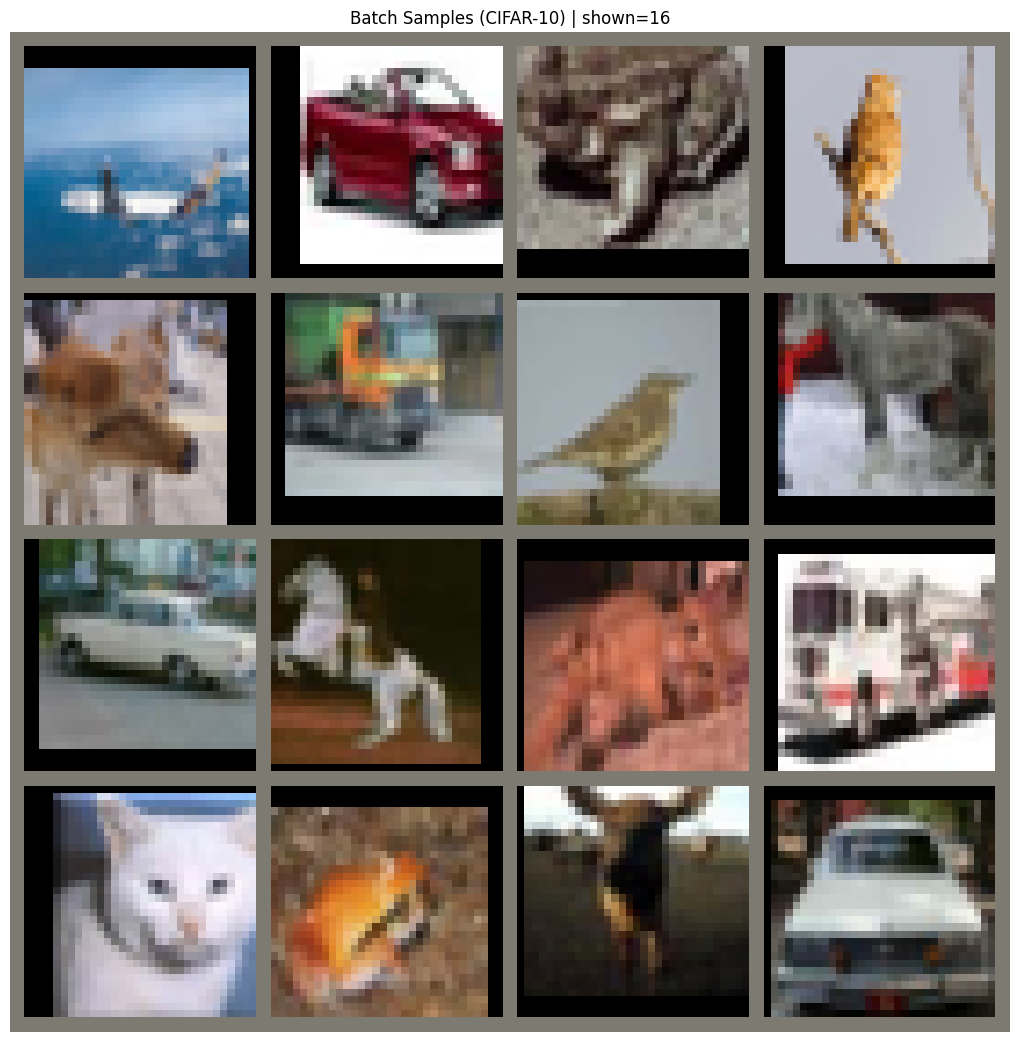

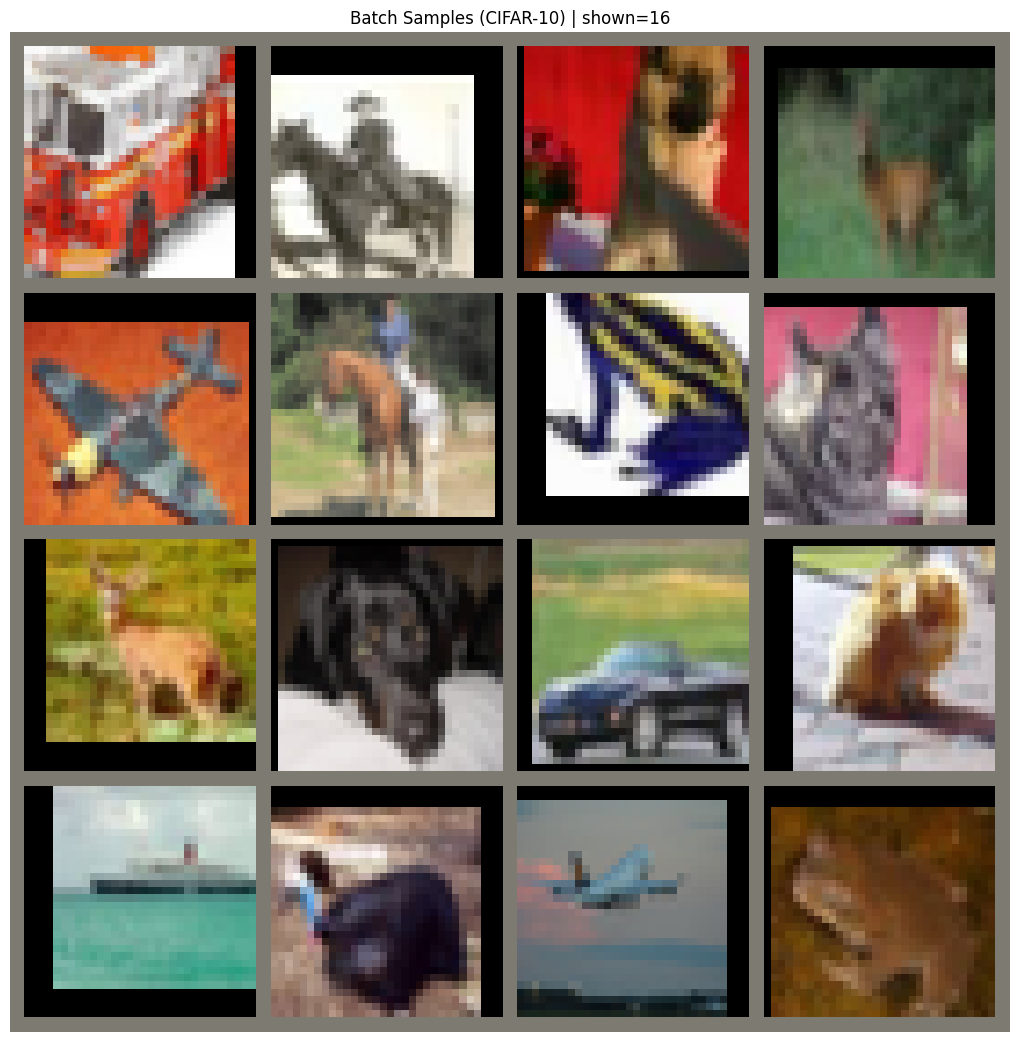

In [4]:
import matplotlib.pyplot as plt
import torch

def denormalize_cifar10(img_chw: torch.Tensor):
    """정규화된 CIFAR-10 텐서(C,H,W)를 시각화용(0~1)으로 되돌립니다."""
    mean = torch.tensor(CIFAR10_MEAN, device=img_chw.device)[:, None, None]
    std  = torch.tensor(CIFAR10_STD,  device=img_chw.device)[:, None, None]
    x = img_chw * std + mean
    return x.clamp(0, 1)

def show_batch(data_loader, max_images: int = 16, nrow: int = 4, figsize=(10, 10)):
    """배치에서 일부 샘플을 보기 좋게 시각화합니다.

    - 기본값은 16장(4×4)을 비교적 크게 보여주는 설정입니다.
    - max_images/nrow/figsize를 바꾸면 '더 적게/더 많이', '더 크게/더 작게'를 조절할 수 있습니다.

    - CIFAR-10은 (C,H,W)=(3,32,32) RGB이므로, 시각화할 때는 (H,W,C)로 바꿔야 합니다.
    - make_grid 결과가 figure 안에서 '밀려 보이는' 경우가 있어, subplot 여백을 0으로 맞춰 꽉 차게 표시합니다.

    Args:
        data_loader: DataLoader
        max_images: 한 번에 보여줄 이미지 개수(기본 16장)
        nrow: grid 한 줄에 배치할 이미지 개수(기본 4개)
        figsize: figure 크기
    """
    batch = next(iter(data_loader))
    images, labels = batch  # images: (B,C,H,W)
    images = images[:max_images]

    # make_grid는 (B,C,H,W) → grid(C,H,W)
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)

    # 시각화는 정규화 해제 후 HWC로 변환
    grid = denormalize_cifar10(grid).detach().cpu().numpy().transpose((1, 2, 0))

    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(grid, interpolation="nearest")
    ax.set_title(f"Batch Samples (CIFAR-10) | shown={len(images)}")
    ax.axis("off")

    # 여백 제거: grid가 4×4에 꽉 차도록
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.show()

# 미리보기: 크게(figure) + 적게(16장) 보기
show_batch(train_loader, max_images=16, nrow=4, figsize=(10, 10))
show_batch(train_loader, max_images=16, nrow=4, figsize=(10, 10))


---
## 2) ViT 모델 구성 개요

ViT는 크게 아래 3단계로 이해하면 읽기 쉬워집니다.

1. **Patch Embedding**  
   이미지(`H×W`)를 `P×P` 패치로 잘라 **토큰 시퀀스**로 바꾸고, 각 패치를 `dim` 차원으로 임베딩합니다.

2. **Transformer Encoder (× depth)**  
   토큰 시퀀스에 대해 반복적으로  
   **(Pre-LN → Multi-Head Self-Attention → Residual) + (Pre-LN → FFN → Residual)** 를 수행합니다.

3. **Classification Head**  
   보통 `[CLS]` 토큰(또는 평균 풀링)을 사용해 최종 분류 로짓을 출력합니다.

> 아래 코드에서 `dim / depth / heads / mlp_dim` 이 무엇을 의미하는지 주석과 함께 확인해 보세요.


In [5]:
def pair(t):  # image_size/patch_size를 (H,W) 형태로 통일하는 유틸
    return t if isinstance(t, tuple) else (t, t)


class PreNorm(nn.Module):  # Transformer의 Pre-LN 구조: LayerNorm 후 블록 실행
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)  # 토큰 임베딩 차원(dim) 기준 LayerNorm -> 패치별 정규화
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)  # 정규화된 토큰을 Attention/FFN에 전달

class FeedForward(nn.Module):  # Transformer의 FFN(MLP) 블록 -> 패치 자체의 정보를 더 깊게 분석
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(  # FFN: Linear→GELU→Dropout→Linear→Dropout 구성
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):  # 멀티헤드 Self-Attention(MHSA) 구현
    def __init__(self, dim, heads = 4, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads  # 전체 헤드 차원 = head 수 × head 차원
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads  # 멀티헤드 개수 저장
        self.scale = dim_head ** -0.5  # Scaled dot-product를 위한 스케일(1/√d)

        self.attend = nn.Softmax(dim = -1)  # attention score를 확률로 변환(softmax), 마지막 차원 : sequence length N
        self.last_attn = None  # (학습/추론 시) 마지막 forward에서의 attention map 저장용(시각화/분석)  # attention score를 확률로 변환(softmax), 마지막 차원 : sequence length N
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)  # 입력 토큰→Q,K,V를 한 번에 선형 변환
        

        self.to_out = nn.Sequential(  # 헤드들을 합친 뒤 출력 투영 + 드롭아웃
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads   # x = [batch Size, tokens, embedding dimension]
        qkv = self.to_qkv(x).chunk(3, dim = -1)  # 선형변환 결과를 Q,K,V로 분할 -> (Q, K ,V)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)  # multi-head 연산을 위해 각 head 기준 n x d 로 분리        

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale  # 각 토큰 간 유사도(Q·Kᵀ) 계산 후 스케일 적용

        attn = self.attend(dots)  # 토큰 간 가중치(attention map) 생성
        self.last_attn = attn.detach()  # 그래프에서 분리(detach)해서 저장 (시각화 목적)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)  # attention 가중합으로 새로운 토큰 표현(out) 계산
        out = rearrange(out, 'b h n d -> b n (h d)')  # 헤드 차원을 다시 합쳐 (batch, tokens, dim)로 복원
        return self.to_out(out)  # 최종 투영을 거쳐 Attention 블록 출력 반환

class Transformer(nn.Module):  # Encoder block을 여러 층(depth) 쌓는 Transformer
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])  # 각 층(Attention+FFN)을 담을 컨테이너
        for _ in range(depth):  # depth 만큼 Encoder block 반복 생성
            self.layers.append(nn.ModuleList([  # 한 층 = (PreNorm+Attention) + (PreNorm+FFN)
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x  # Residual 연결: Attention 결과를 입력에 더해 정보 보존
            x = ff(x) + x  # Residual 연결: FFN 결과를 입력에 더해 정보 보존
        return x


---
## 2-1) ViTConfig + ViT(모델 본체) 구현

- **목적:** ViT의 핵심 구성 요소(패치 임베딩, CLS 토큰, 위치 임베딩, Transformer Encoder 블록, 분류 헤드)를 **코드로 직접 확인**합니다.
- **관찰 포인트**
  - `image_size`, `patch_size` → 패치 개수(`num_patches`)와 토큰 시퀀스 길이가 어떻게 결정되는지
  - `depth`(블록 개수), `heads`(멀티헤드 수), `dim`(토큰 임베딩 차원)이 **연산량/표현력**에 어떤 영향을 주는지
  - **Pre-LN + Residual** 구조가 어디에 적용되는지(안정적인 학습을 위한 표준 패턴)


In [6]:
from dataclasses import dataclass  # 설정값을 묶어 init 인자를 단순화하기 위한 도구
from typing import Tuple, Union  # 파이썬 버전 호환을 위한 타입 힌트

@dataclass
class ViTConfig:
    # 입력/토큰화 관련
    image_size: 'Union[int, Tuple[int, int]]'          # 입력 이미지 크기 (H, W) 또는 정수(정수면 정사각형)
    patch_size: 'Union[int, Tuple[int, int]]'          # 패치 크기 (Ph, Pw) 또는 정수
    channels: int = 3                          # 입력 채널 수 (CIFAR-10=3, MNIST=1)

    # 모델 본체(Encoder) 관련
    dim: int = 64                              # 토큰 임베딩 차원(Transformer의 hidden size)
    depth: int = 6                             # Encoder 블록 개수(= Transformer layer 수)
    heads: int = 4                             # Multi-Head Self-Attention의 head 개수
    dim_head: int = 64                         # 각 head의 Q/K/V 차원
    mlp_dim: int = 128                         # FFN(MLP) 중간 차원

    # 분류/출력 관련
    num_classes: int = 10                      # 분류 클래스 수
    pool: str = "cls"                          # "cls": CLS 토큰 사용, "mean": 토큰 평균 풀링
    dropout: float = 0.0                       # Encoder 내부 dropout(Attention/FFN)
    emb_dropout: float = 0.0                   # 패치+포지션 임베딩 단계 dropout


class ViT(nn.Module):
    """Vision Transformer (ViT)
    - 이미지를 패치로 쪼개 토큰 시퀀스를 만들고
    - CLS 토큰 + 위치 임베딩을 더한 뒤
    - Transformer Encoder로 전역(Self-Attention) 관계를 학습하여
    - CLS(또는 mean pool) 표현으로 분류합니다.
    """

    def __init__(self, cfg: ViTConfig):
        super().__init__()

        # 1) 입력 해상도/패치 크기를 (H,W) 튜플로 정규화
        image_height, image_width = pair(cfg.image_size)
        patch_height, patch_width = pair(cfg.patch_size)

        # 2) 패치가 이미지에 딱 나누어 떨어져야 (h, w) 그리드가 정확히 형성됨
        assert image_height % patch_height == 0 and image_width % patch_width == 0, "Image dimensions must be divisible by the patch size."

        # 3) 패치 개수(=토큰 개수)와 한 패치의 펼친 차원 계산
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = cfg.channels * patch_height * patch_width

        # 4) 풀링 방식 검증: CLS 토큰을 쓸지 mean pool을 쓸지 선택
        assert cfg.pool in {"cls", "mean"}, "pool must be 'cls' or 'mean'"

        # 5) 패치 토큰화: (B,C,H,W) -> (B, N, patch_dim) -> (B, N, dim)
        self.to_patch_embedding = nn.Sequential(
            # 패치 그리드로 자른 뒤, 각 패치를 1D 벡터로 펼쳐 토큰 시퀀스를 만듦
            Rearrange(
                "b c (h p1) (w p2) -> b (h w) (p1 p2 c)",
                p1=patch_height,
                p2=patch_width,
            ),
            # 펼친 패치 벡터를 Transformer hidden size(dim)로 선형 투영
            nn.Linear(patch_dim, cfg.dim),
        )

        # 6) CLS 토큰 + 위치 임베딩(학습 파라미터)
        self.cls_token = nn.Parameter(torch.randn(1, 1, cfg.dim))
        # LLM GPT의 token embedding 대신 cls_token으로 분류하는 방식인듯?
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, cfg.dim))
        self.dropout = nn.Dropout(cfg.emb_dropout)

        # 7) Transformer Encoder 스택(Attention + FFN + Residual/PreNorm)
        self.transformer = Transformer(
            dim=cfg.dim,
            depth=cfg.depth,
            heads=cfg.heads,
            dim_head=cfg.dim_head,
            mlp_dim=cfg.mlp_dim,
            dropout=cfg.dropout,
        )

        self.pool = cfg.pool

        # 8) 분류 헤드: (CLS/mean) 표현 -> LayerNorm -> Linear(logits)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(cfg.dim),
            nn.Linear(cfg.dim, cfg.num_classes),
        )

    def forward(self, img):
        # A) 패치 임베딩으로 토큰 시퀀스 생성: (B,C,H,W) -> (B,N,dim)
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        # B) CLS 토큰을 배치만큼 복제해 시퀀스 맨 앞에 붙임: (B,1,dim)
        cls_tokens = repeat(self.cls_token, "1 1 d -> b 1 d", b=b)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, dim)

        # C) 위치 임베딩을 더해 토큰 순서(공간 위치) 정보를 주입
        x = x + self.pos_embedding[:, : (n + 1)]   # (B, N+1, dim) + (1, N+1, dim) -> Broadcasting
        x = self.dropout(x)

        # D) Encoder를 통과하며 전역 의존성(Self-Attention) 학습
        x = self.transformer(x)  # (B, N+1, dim)

        # E) 이미지 표현 벡터 선택: CLS 토큰(0번) 또는 mean pooling
        x = x[:, 0] if self.pool == "cls" else x.mean(dim=1)   # (B, dim)

        # F) 최종 logits 출력 (softmax는 CrossEntropyLoss 내부에서 처리)
        return self.mlp_head(x)


---
## 2-2) ViT 하이퍼파라미터 설정 (vit_cfg)

- **목적:** ViT의 구조를 결정하는 설정값을 한 곳에서 정의하고, 아래 `ViT(vit_cfg)`가 **어떤 형태의 모델**을 만드는지 연결해 봅니다.
- **관찰 포인트**
  - `patch_size`가 작아질수록 토큰 수가 늘어 **Self-Attention 비용**이 증가합니다.
  - `depth/heads/dim`은 성능뿐 아니라 **학습 시간·메모리**에도 직접 영향을 줍니다.
  - CIFAR-10(32×32, RGB)에서도 과도한 설정은 **학습 불안정/과적합**을 유발할 수 있습니다.


In [7]:
# ViT 설정을 한 곳에 모아두면(=config) 모델 구조를 한눈에 파악하기 쉽습니다.
vit_cfg = ViTConfig(
        image_size=32,      # CIFAR-10: 32x32
    patch_size=4,       # 4x4 패치 -> (32/4)^2 = 64개 패치 토큰
        channels=3,         # CIFAR-10은 컬러(3채널)
    dim=64,             # 토큰 임베딩 차원
    depth=6,            # Encoder 블록 수
    heads=4,            # MHSA head 수
    dim_head=64,        # head당 Q/K/V 차원
    mlp_dim=128,        # FFN 중간 차원
    num_classes=10,     # 0~9
    pool="cls",         # CLS 토큰으로 분류
    dropout=0.0,        # Encoder dropout
    emb_dropout=0.0,    # 임베딩 dropout
)

model = ViT(vit_cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)    # Momentum + RMSProp


## 4) 체크포인트 저장/이어학습(Resume)

- **목적:** 학습 결과를 `ckpt_path`로 저장하고, 파일이 있으면 **이어서 추가 학습**합니다.
- **관찰 포인트**
  - 체크포인트가 있을 때: `start_epoch`부터 이어서 **추가 10 epoch**
  - 체크포인트가 없을 때: 처음부터 **20 epoch**


In [8]:
# 체크포인트(ckpt) 저장/로드
# - ckpt 파일이 있으면: 이어서 추가 5 epoch 학습(resume)
# - ckpt 파일이 없으면: 처음부터 10 epoch 학습

ckpt_path = "vit_cifar10.pth"  # 필요시 파일명/경로만 바꿔서 사용하세요.
start_epoch = 0
last_acc = 0.0  # 체크포인트가 있을 때 로드되는 이전 test accuracy

if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    start_epoch = int(ckpt.get("epoch", 0))
    last_acc = float(ckpt.get("test_acc", 0.0))
    print(f"[ckpt] Loaded: {ckpt_path} (epoch={start_epoch}, test_acc={last_acc*100:.2f}%)")
    extra_epochs = 10
else:
    print(f"[ckpt] Not found: {ckpt_path} -> train from scratch")
    extra_epochs = 20


# best_acc: 지금까지 저장된 체크포인트 중 최고 정확도(업데이트 기준)
best_acc = last_acc

target_epoch = start_epoch + extra_epochs
print(f"[plan] Train epochs: {start_epoch+1} .. {target_epoch} (total {extra_epochs} epoch(s))")


C:\Users\swsuser-i9\AppData\Local\Temp\ipykernel_19100\3675719215.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


[ckpt] Loaded: vit_cifar10.pth (epoch=30, test_acc=74.02%)
[plan] Train epochs: 31 .. 40 (total 10 epoch(s))


---
## 3) 모델 구조 요약 & 파라미터 수 확인

- **목적**: 레이어 구성을 빠르게 보고, 학습 가능한 파라미터 규모를 숫자로 확인합니다.
- **관찰 포인트:**
  - Patch Embedding이 만들어내는 토큰 수(= 패치 개수 + 1[CLS])
  - Encoder 블록이 `depth`만큼 반복되는지
  - 마지막 분류 헤드(Linear)가 어디에 붙는지
  - `dim/depth/heads`를 키우면 파라미터/연산량이 어떻게 커지는지

In [9]:
# (1) 모델 구조 요약: 레이어와 텐서 흐름을 빠르게 확인
# torchinfo.summary는 입력 텐서 크기를 알면 훨씬 정확한 구조를 출력합니다.
_summary = summary(model, input_size=(1, 3, 32, 32), device=str(device))
print(_summary)

# (2) 학습 가능한 파라미터 수: 모델 '규모'를 숫자로 확인
def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print("Trainable parameters:", count_parameters(model))


Layer (type:depth-idx)                             Output Shape              Param #
ViT                                                [1, 10]                   4,224
├─Sequential: 1-1                                  [1, 64, 64]               --
│    └─Rearrange: 2-1                              [1, 64, 48]               --
│    └─Linear: 2-2                                 [1, 64, 64]               3,136
├─Dropout: 1-2                                     [1, 65, 64]               --
├─Transformer: 1-3                                 [1, 65, 64]               --
│    └─ModuleList: 2-3                             --                        --
│    │    └─ModuleList: 3-1                        --                        82,432
│    │    └─ModuleList: 3-2                        --                        82,432
│    │    └─ModuleList: 3-3                        --                        82,432
│    │    └─ModuleList: 3-4                        --                        82,432
│    │    └─M

---
## 4) Training (학습 루프)

- **목적:** ViT를 CIFAR-10 학습 데이터로 학습시켜, *토큰 기반 분류가 실제로 동작*하는 것을 확인합니다.
- **관찰 포인트:**
  - `model.train()` 상태에서 **드롭아웃/정규화**가 어떻게 동작하는지
  - 손실(loss)이 줄어드는지(학습이 되는지)



In [10]:
def train_epoch(model, optimizer, data_loader, loss_history):
    """한 epoch 학습을 수행하고, 진행 상황을 epoch당 '딱 5번'만 출력합니다."""
    total_samples = len(data_loader.dataset)
    model.train()

    # epoch당 출력 5회(0%, 25%, 50%, 75%, 마지막)로 고정
    n_steps = len(data_loader)
    log_steps = {
        0,
        max(0, n_steps // 4),
        max(0, n_steps // 2),
        max(0, (3 * n_steps) // 4),
        n_steps - 1,
    }

    for i, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)  # Softmax
        loss = F.nll_loss(output, target)           # Negative Log Likelihood
        # nn.CrossEntropyLoss(model(data), target)
        loss.backward()
        optimizer.step()

        if i in log_steps:
            seen = min((i + 1) * len(data), total_samples)
            print(f"[{seen:5d}/{total_samples:5d} ({100.0 * (i+1) / n_steps:5.1f}%)]  Loss: {loss.item():.4f}")
            loss_history.append(loss.item())

In [11]:
def evaluate(model, data_loader, loss_history):
    """test_loader로 1회 평가하고 (loss, acc)를 반환합니다."""
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)

            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += float(loss.item())
            correct_samples += int(pred.eq(target).sum().item())

    avg_loss = total_loss / total_samples
    acc = correct_samples / total_samples

    loss_history.append(avg_loss)
    print(
        f"Average test loss: {avg_loss:.4f}  "
        f"Accuracy: {correct_samples:5d}/{total_samples:5d} ({acc*100:.2f}%)\n"
    )
    return avg_loss, acc


> 참고: CPU로 실행하면 epoch 당 시간이 꽤 걸릴 수 있습니다.  
> 가능하면 GPU 환경에서 실행하는 것을 권장합니다. (CIFAR-10는 작지만, Transformer는 토큰 연산이 많습니다.)


---
## 5) Training (학습)

- **목적:** 학습 데이터로 파라미터를 업데이트합니다.
- **관찰 포인트:**
  - `model.train()` 모드에서 Dropout/BN 등이 어떻게 동작하는지
  - Loss가 epoch이 진행되며 감소하는지(과적합/학습 실패 징후 관찰)
  - 매 epoch 평가 후, **정확도가 개선된 경우에만(best) 체크포인트를 업데이트**합니다.

In [12]:
# ckpt 기준으로 학습 epoch 수가 자동 결정됩니다.
# - ckpt가 있으면(start_epoch>0): 이어서 추가 10 epoch
# - ckpt가 없으면(start_epoch=0): 처음부터 20 epoch

start_time = time.time()

train_loss_history = []
test_loss_history = []

for epoch in range(start_epoch + 1, target_epoch + 1):
    print(f"Epoch: {epoch}/{target_epoch}")

    # 학습
    train_epoch(model, optimizer, train_loader, train_loss_history)

    # 매 epoch마다 test set으로 1회 평가(accuracy 출력)
    test_loss, test_acc = evaluate(model, test_loader, test_loss_history)

    # 정확도가 '개선'된 경우에만 체크포인트를 업데이트합니다.
    # - 이렇게 하면 가장 좋은(best) 모델만 ckpt_path에 남습니다.
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(
            {
                "epoch": epoch,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "test_acc": test_acc,
                "test_loss": test_loss,
                "vit_cfg": getattr(vit_cfg, "__dict__", dict(vit_cfg=repr(vit_cfg))),
            },
            ckpt_path,
        )
        print(f"[ckpt] Updated(best): {ckpt_path} (epoch={epoch}, best_acc={best_acc*100:.2f}%)\n")
    else:
        print(f"[ckpt] Skip (not improved): best_acc={best_acc*100:.2f}% (this={test_acc*100:.2f}%)\n")

print("Execution time:", "{:5.2f}".format(time.time() - start_time), "seconds")


Epoch: 31/40
[  256/50000 (  0.5%)]  Loss: 0.6254
[12800/50000 ( 25.5%)]  Loss: 0.7495
[25344/50000 ( 50.5%)]  Loss: 0.6874
[37888/50000 ( 75.5%)]  Loss: 0.6787
[15680/50000 (100.0%)]  Loss: 0.6928
Average test loss: 0.7201  Accuracy:  7498/10000 (74.98%)

[ckpt] Updated(best): vit_cifar10.pth (epoch=31, best_acc=74.98%)

Epoch: 32/40
[  256/50000 (  0.5%)]  Loss: 0.5394
[12800/50000 ( 25.5%)]  Loss: 0.6501
[25344/50000 ( 50.5%)]  Loss: 0.6541
[37888/50000 ( 75.5%)]  Loss: 0.6715
[15680/50000 (100.0%)]  Loss: 0.6392
Average test loss: 0.7276  Accuracy:  7433/10000 (74.33%)

[ckpt] Skip (not improved): best_acc=74.98% (this=74.33%)

Epoch: 33/40
[  256/50000 (  0.5%)]  Loss: 0.6895
[12800/50000 ( 25.5%)]  Loss: 0.6015
[25344/50000 ( 50.5%)]  Loss: 0.7346
[37888/50000 ( 75.5%)]  Loss: 0.6892
[15680/50000 (100.0%)]  Loss: 0.7138
Average test loss: 0.7447  Accuracy:  7395/10000 (73.95%)

[ckpt] Skip (not improved): best_acc=74.98% (this=73.95%)

Epoch: 34/40
[  256/50000 (  0.5%)]  Loss: 0

---
## 6) Testing (Attention)

- **목적:** ViT의 예측이 어떤 **패치(토큰)** 정보에 의존하는지, CLS 토큰의 attention을 통해 직관적으로 확인합니다.
- **관찰 포인트:**
  - CLS 토큰이 **어떤 위치(패치)** 에 강하게 attention을 주는지
  - layer/head를 바꾸면 attention 패턴이 어떻게 달라지는지
  - (선택) **정답/오답 샘플**에서 attention이 얼마나 설득력 있게 보이는지

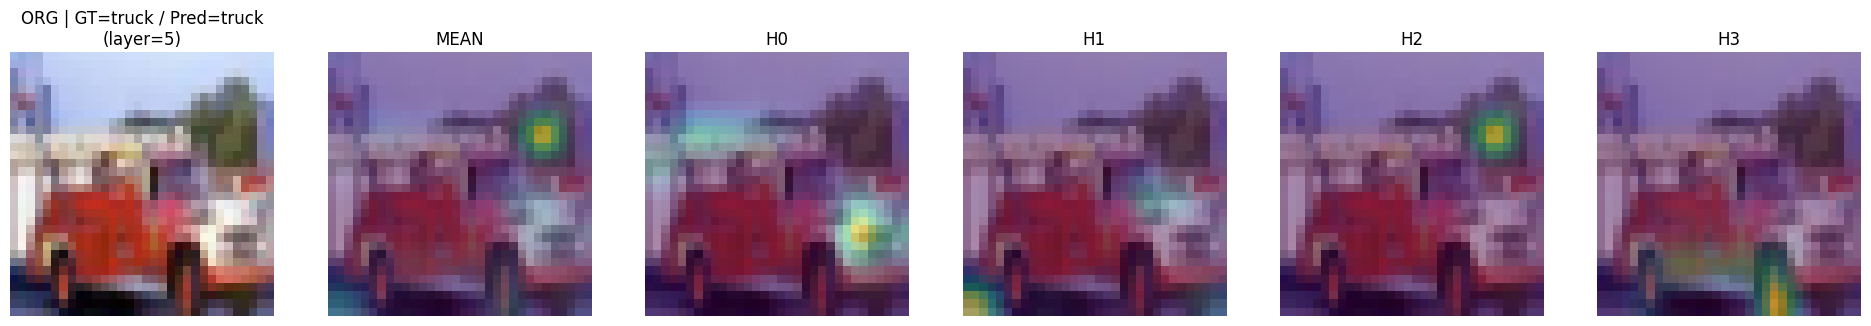

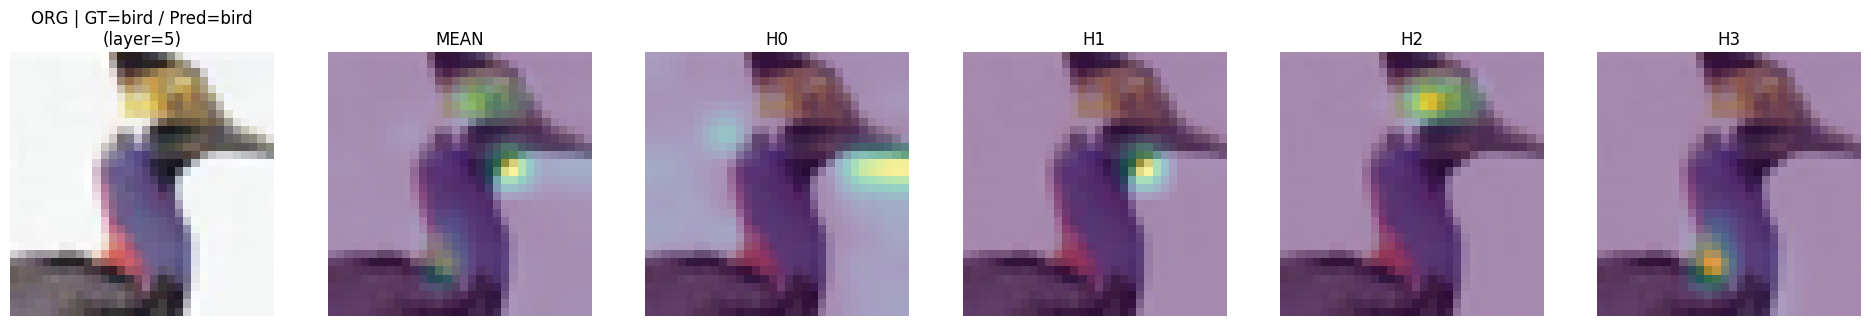

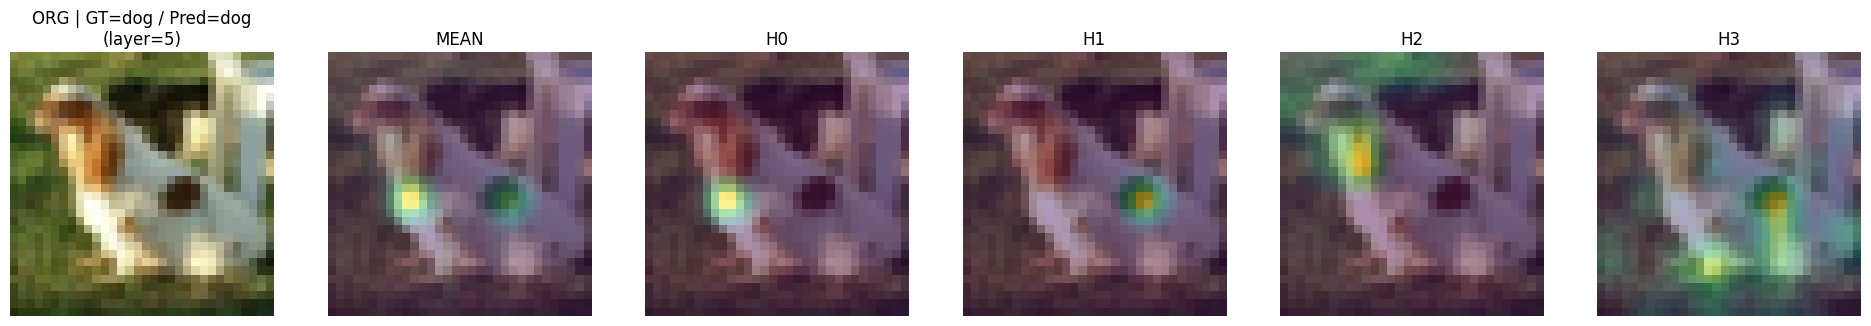

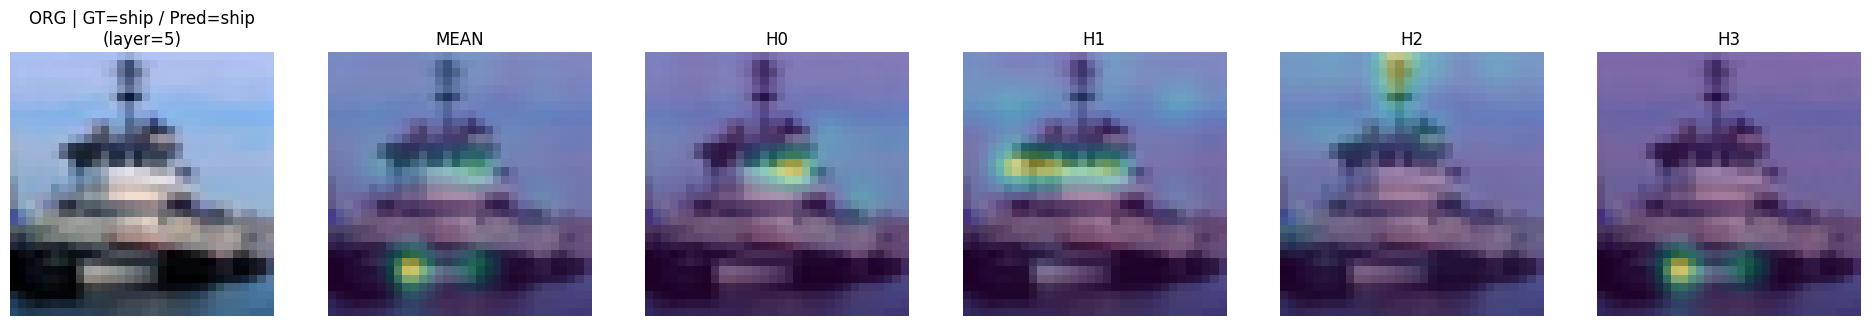

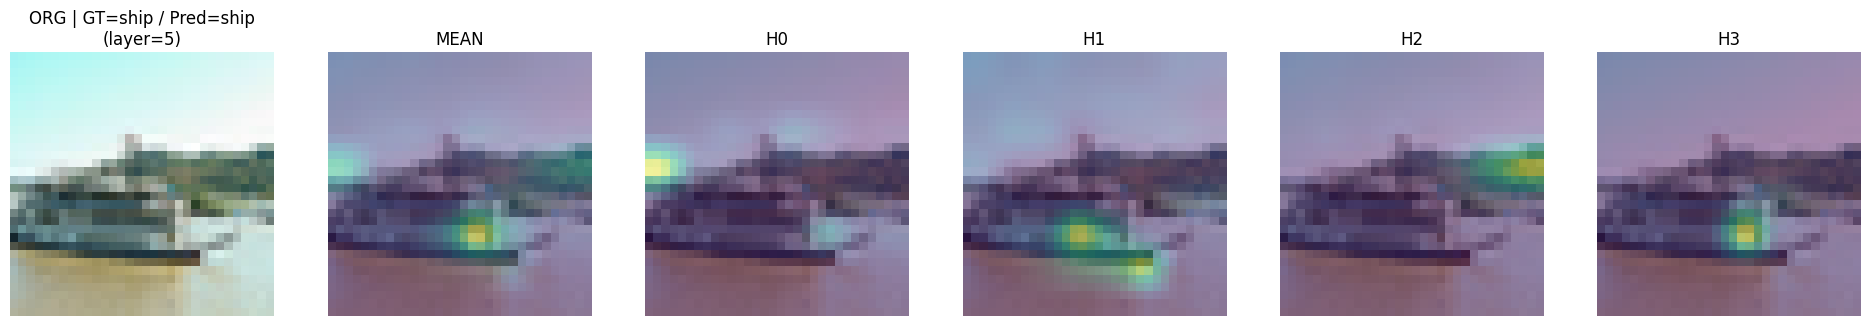

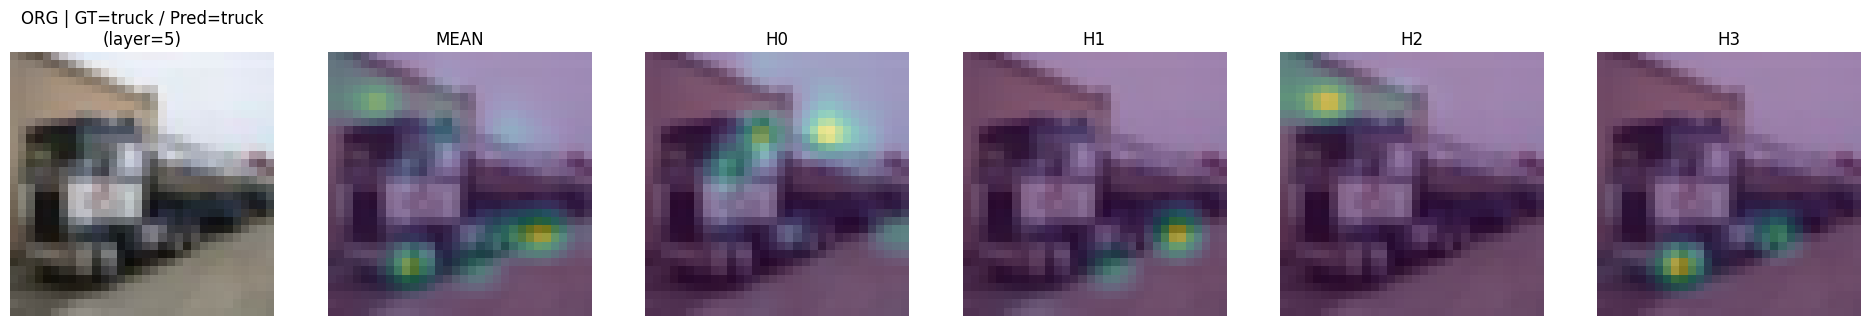

In [13]:
# (실습) Testing (Attention): ViT가 '어디를 보고' 예측했는지(=CLS→Patch Attention) 시각화
# - 마지막 logits는 CLS 토큰에서 나오므로, "CLS 토큰이 어떤 패치 토큰들을 참고했는지"를 보면 모델의 단서를 얻을 수 있습니다.
# - 실무/연구 관점에서도 초기 레이어(layer_idx=0)는 저수준/분산된 패턴이 많아 해석이 애매한 경우가 많아서,
#   기본값은 "맨 마지막 Transformer 블록"의 attention을 보는 쪽이 직관적입니다.
# - 또한 'head 평균'뿐 아니라 '각 head'가 서로 다른 패턴을 볼 수 있으므로, 여러 head를 한 번에 오버레이해서 비교합니다.

import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import random


def denormalize_cifar10_chw(img_chw: torch.Tensor):
    """정규화된 CIFAR-10 이미지(C,H,W)를 시각화용(0~1)으로 복원합니다."""
    mean = torch.tensor(CIFAR10_MEAN, device=img_chw.device)[:, None, None]
    std  = torch.tensor(CIFAR10_STD,  device=img_chw.device)[:, None, None]
    x = img_chw * std + mean
    return x.clamp(0, 1)


def chw_to_hwc_np(img_chw: torch.Tensor) -> np.ndarray:
    """(C,H,W) 텐서를 matplotlib imshow용 (H,W,C) numpy로 변환합니다.
    - CIFAR-10은 정규화가 적용되어 있으므로 denormalize 후 표시합니다.
    """
    x = denormalize_cifar10_chw(img_chw)  # (C,H,W), 0~1
    x = x.detach().cpu()
    # (C,H,W) -> (H,W,C)
    x_hwc = x.permute(1, 2, 0).numpy()
    return x_hwc

def imshow_chw(ax, img_chw: torch.Tensor, title: str = None):
    """CHW 텐서를 안전하게 imshow합니다."""
    x_hwc = chw_to_hwc_np(img_chw)
    ax.imshow(x_hwc)
    ax.axis("off")
    if title is not None:
        ax.set_title(title)


def _extract_last_attn(model, layer_idx: int):
    """지정한 encoder 블록(layer)의 Attention 모듈이 저장해둔 last_attn을 꺼냅니다.
    - Attention.forward에서 self.last_attn = attn.detach()로 저장하도록 구현되어 있어야 합니다.
    - 반환 shape: [B, H, N, N] (B=batch, H=head, N=tokens=1+num_patches)
    """
    # transformer.layers[layer_idx] = (PreNorm(Attention), PreNorm(FFN)) 형태를 가정
    attn_module = model.transformer.layers[layer_idx][0].fn  # [0]:Attention, [1]: FF, PreNorm(fn=Attention)
    attn = attn_module.last_attn
    if attn is None:
        raise RuntimeError("Attention.last_attn이 비어 있습니다. 먼저 model(x)를 한 번 forward 해야 합니다.")
    return attn  # [B,H,N,N]

def _cls_to_patch_map(attn_bhNN, head_idx=None):
    """[B,H,N,N] attention에서 CLS→Patch attention만 뽑아 1D로 반환합니다.
    - CLS 토큰 index = 0
    - Patch 토큰 index = 1..N
    - head_idx=None이면 head 평균을 사용합니다.
    반환: cls_attn_1d shape = [num_patches]
    """
    # CLS(0) 가 각 토큰(j)에 주는 attention: attn[..., 0, j]
    if head_idx is None:
        # head 평균: [B,N] (여기서는 B=1 가정)
        cls_attn = attn_bhNN.mean(dim=1)[0, 0, 1:]  # 평균 관심지도 [1, H, N+1, N+1] → [1, N+1, N+1] → [N]
    else:
        cls_attn = attn_bhNN[0, head_idx, 0, 1:]    # 특정헤드 관심지도 [N]
    return cls_attn

def _to_2d_grid(cls_attn_1d, grid_h: int, grid_w: int):
    """[num_patches] 1D attention을 (grid_h, grid_w)로 reshape합니다."""
    attn_2d = cls_attn_1d.reshape(grid_h, grid_w)
    # 0~1 범위로 정규화(시각화 안정성)
    attn_2d = attn_2d - attn_2d.min()
    attn_2d = attn_2d / (attn_2d.max() + 1e-8)
    return attn_2d

def _upsample_to_image(attn_2d, out_h: int, out_w: int):
    """(grid_h,grid_w) attention을 (out_h,out_w)로 bilinear upsample합니다."""
        # attn_2d가 이미 Tensor일 수도 있으므로, 불필요한 tensor(...) 재구성을 피합니다.
    if isinstance(attn_2d, torch.Tensor):
        attn_t = attn_2d.detach().float().unsqueeze(0).unsqueeze(0)  # [1,1,gh,gw] -> gray image
    else:
        attn_t = torch.as_tensor(attn_2d, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1,1,gh,gw] -> gray image
    attn_up = F.interpolate(attn_t, size=(out_h, out_w), mode="bilinear", align_corners=False)[0,0] # [32, 32]
    attn_up = attn_up - attn_up.min()
    attn_up = attn_up / (attn_up.max() + 1e-8)
    return attn_up.cpu().numpy()  # (out_h,out_w)

def _get_attention_maps_for_image(model, x1, vit_cfg, layer_idx=None, head_idx=None):
    """단일 이미지(x1)에 대해 attention map(overlay용)을 준비합니다.
    - layer_idx=None 또는 layer_idx==0 이면 '맨 마지막 레이어'로 자동 설정합니다(해석 용이).
    - head_idx=None 이면 'head 평균'을 반환.
    - head_idx가 정수면 해당 head만 반환.
    반환: (maps, used_layer_idx)
      - maps: list of (title, attn_up_HxW)
    """
    model.eval()
    with torch.no_grad():
        _ = model(x1)

    # (중요) 기본값: 마지막 레이어를 사용
    depth = int(vit_cfg.depth)
    used_layer_idx = (depth - 1) if (layer_idx is None or layer_idx == 0) else int(layer_idx)

    attn_bhNN = _extract_last_attn(model, used_layer_idx)  # [1,H,N,N]

    # patch grid 크기 = (H/patch, W/patch)
    ps = int(vit_cfg.patch_size) if not isinstance(vit_cfg.patch_size, tuple) else int(vit_cfg.patch_size[0])
    # 입력 이미지 크기 (CIFAR-10: 32x32, MNIST: HxW 등)에서 patch grid 크기를 계산합니다.
    if isinstance(vit_cfg.image_size, tuple):
        img_h, img_w = int(vit_cfg.image_size[0]), int(vit_cfg.image_size[1])
    else:
        img_h, img_w = int(vit_cfg.image_size), int(vit_cfg.image_size)

    grid_h, grid_w = img_h // ps, img_w // ps

    maps = []
    if head_idx is None:
        # head 평균 1장
        cls_1d = _cls_to_patch_map(attn_bhNN, head_idx=None)
        attn_2d = _to_2d_grid(cls_1d, grid_h, grid_w)
        maps.append(("MEAN", _upsample_to_image(attn_2d, out_h=img_h, out_w=img_w)))
    else:
        # 특정 head 1장
        cls_1d = _cls_to_patch_map(attn_bhNN, head_idx=int(head_idx))
        attn_2d = _to_2d_grid(cls_1d, grid_h, grid_w)
        maps.append((f"H{int(head_idx)}", _upsample_to_image(attn_2d, out_h=img_h, out_w=img_w)))

    return maps, used_layer_idx

def show_attention_overlays(
    model,
    test_set,
    vit_cfg,
    device,
    n_samples: int = 6,
    layer_idx=None,
    head_idx=None,
    show_all_heads: bool = True,
    sample_mode: str = "correct",  # "correct" | "incorrect" | "all"
    seed: int = 0,
):
    """여러 이미지에 대해 ORG(원본) + attention overlay를 나란히 보여줍니다.

    Args:
        model: 학습된 ViT 모델
        test_set: (image, label) 형태의 dataset
        vit_cfg: ViTConfig (depth, heads, patch_size 등)
        device: torch.device
        n_samples: 출력할 샘플 개수
        layer_idx: 보고 싶은 encoder 블록 인덱스
            - None 또는 0이면 마지막 레이어(depth-1)로 자동 설정(권장)
        head_idx: 보고 싶은 head 인덱스
            - None이면 head 평균(MEAN)
        show_all_heads: True면 마지막 레이어의 모든 head(H0..H{heads-1})도 함께 출력
        sample_mode: "correct"/"incorrect"/"all" 로 샘플 필터링
        seed: 랜덤 샘플링 재현성

    출력:
        각 샘플마다 [ORG] + [MEAN] + [H0..] 형태로 한 줄(row)로 표시합니다.
    """
    random.seed(seed)

    # 1) 샘플 후보 인덱스 준비
    indices = list(range(len(test_set)))

    # 2) 필요 시: 샘플 필터링 (correct/incorrect/all)
    # sample_mode에 따라 후보를 거릅니다.
    # - "correct"   : 정답(=맞춘) 샘플만
    # - "incorrect" : 오답(=틀린) 샘플만
    # - "all"       : 전체(필터 없음)
    sample_mode = (sample_mode or "all").lower().strip()
    if sample_mode not in {"correct", "incorrect", "all"}:
        print(f"[warn] sample_mode={sample_mode} 는 지원하지 않습니다. -> 'all'로 처리합니다.")
        sample_mode = "all"

    if sample_mode in {"correct", "incorrect"}:
        filtered = []
        model.eval()
        with torch.no_grad():
            for idx in indices:
                x, y = test_set[idx]
                x1 = x.unsqueeze(0).to(device)  # (1, 3, 32, 32)
                logits = model(x1)
                pred = int(logits.argmax(dim=1).item())
                is_correct = (pred == int(y))
                if (sample_mode == "correct" and is_correct) or (sample_mode == "incorrect" and (not is_correct)):
                    filtered.append(idx)

        indices = filtered
        if len(indices) == 0:
            msg = "정답" if sample_mode == "correct" else "오답"
            print(f"[warn] 조건에 맞는 {msg} 샘플이 없습니다. (모델 학습 상태/seed/n_samples를 확인하세요.)")
            return

    # 3) 샘플링
    chosen = random.sample(indices, k=min(n_samples, len(indices))) if len(indices) > 0 else []

    # 4) 시각화: 샘플마다 ORG + (MEAN + Heads) 를 한 row로 출력
    heads = int(vit_cfg.heads)
    for idx in chosen:
        x, y = test_set[idx]
        label = int(y)

        x1 = x.unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            logits = model(x1)
            pred = int(logits.argmax(dim=1).item())

        # (A) 평균 attention(MEAN)
        mean_maps, used_layer = _get_attention_maps_for_image(
            model=model, x1=x1, vit_cfg=vit_cfg,
            layer_idx=layer_idx, head_idx=None
        )

        # (B) 각 head attention(H0..)
        head_maps = []
        if show_all_heads:
            for h in range(heads):
                hm, _ = _get_attention_maps_for_image(
                    model=model, x1=x1, vit_cfg=vit_cfg,
                    layer_idx=layer_idx, head_idx=h
                )
                head_maps.extend(hm)  # hm은 1개짜리 리스트

        # 표시할 컬럼 구성: ORG + MEAN + heads...
        maps_to_show = mean_maps + head_maps

        ncols = 1 + len(maps_to_show)
        fig, axes = plt.subplots(1, ncols, figsize=(3.2 * ncols, 3.2))

        # ORG(원본)
        ax0 = axes[0]
        imshow_chw(ax0, x, title=None)
        ax0.axis("off")
        ax0.set_title(f"ORG | GT={class_names[int(label)]} / Pred={class_names[int(pred)]}\n(layer={used_layer})")

        # Overlays
        for j, (title, attn_up) in enumerate(maps_to_show, start=1):
            ax = axes[j]
            base = chw_to_hwc_np(x)  # (H,W,3), 0~1
            ax.imshow(base)
            ax.imshow(attn_up, alpha=0.45)  # heatmap overlay (컬러맵 기본값 사용)
            ax.axis("off")
            ax.set_title(f"{title}")

        plt.tight_layout()
        plt.show()

# 사용 예시:
# - 기본값(layer_idx=None): 마지막 레이어의 MEAN + 모든 head를 출력
# - sample_mode="incorrect": 오답 샘플만 골라서 보면 해석이 더 쉬운 경우가 많습니다.
show_attention_overlays(
    model=model,
    test_set=test_set,
    vit_cfg=vit_cfg,
    device=device,
    n_samples=6,
    layer_idx=None,           # None 또는 0이면 마지막 레이어를 사용
    head_idx=None,            # None이면 평균(MEAN)
    show_all_heads=True,      # 모든 head도 함께 보기
    sample_mode="correct",
    seed=0,
)

---
## 7) Confusion Matrix로 오분류 패턴 보기

- **목적:** 단순 정확도(accuracy)만으로는 보이지 않는 **클래스별 오분류 경향**을 확인합니다.
- **관찰 포인트:**
  - 어떤 클래스 쌍(예: `cat↔dog`, `automobile↔truck`, `deer↔horse`)이 자주 헷갈리는지
  - 특정 클래스에서만 오분류가 집중되는지(데이터/모델 편향 가능성)
  - 이후 `오분류 샘플 시각화`와 함께 보면 “왜” 틀렸는지 해석이 쉬워집니다.


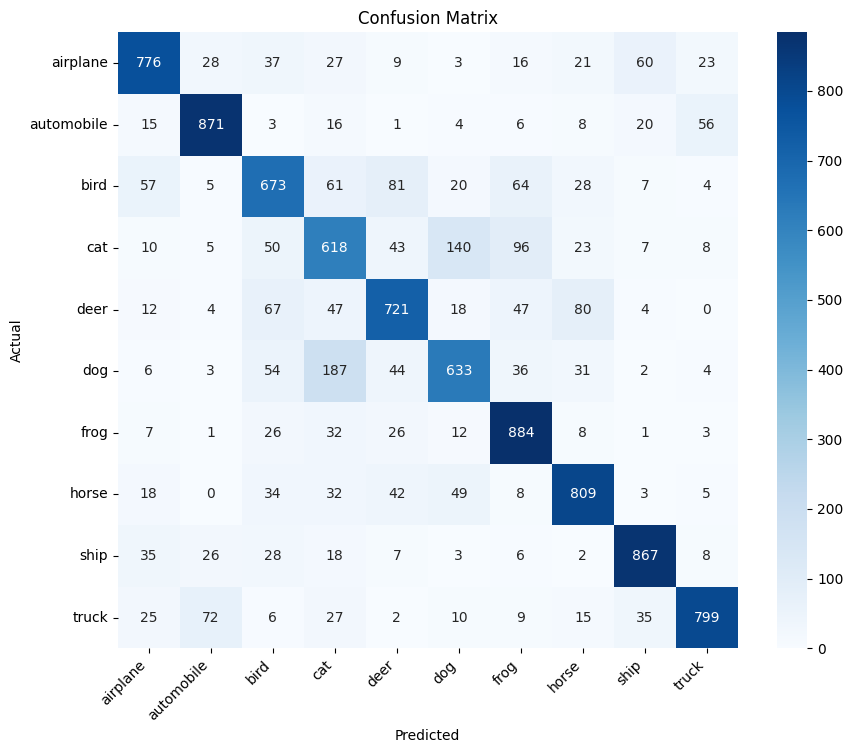

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)  # 입력 배치에 대한 모델 forward(로짓 출력)
            _, preds = torch.max(output, dim=1)   # preds = maximum indices
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader)


---
## 8) 오분류(실패) 샘플만 시각화하기

- **목적:** 단순히 "맞춘 샘플"을 보는 것보다, **틀린 샘플(오분류)** 을 모아 보면 모델이 약한 패턴을 빠르게 파악할 수 있습니다.
- **어떻게 해석할까?**
  - 비슷한 클래스(예: `cat↔dog`, `automobile↔truck`)에서 헷갈리는지
  - 배경(하늘/풀/도로 등)이나 객체 크기/각도/가림(occlusion)에 민감한지
  - 데이터 증강(augmentation)이나 모델 크기/학습률 조절이 필요한지

아래 함수는 **오분류된 샘플만** 골라서 그려줍니다.


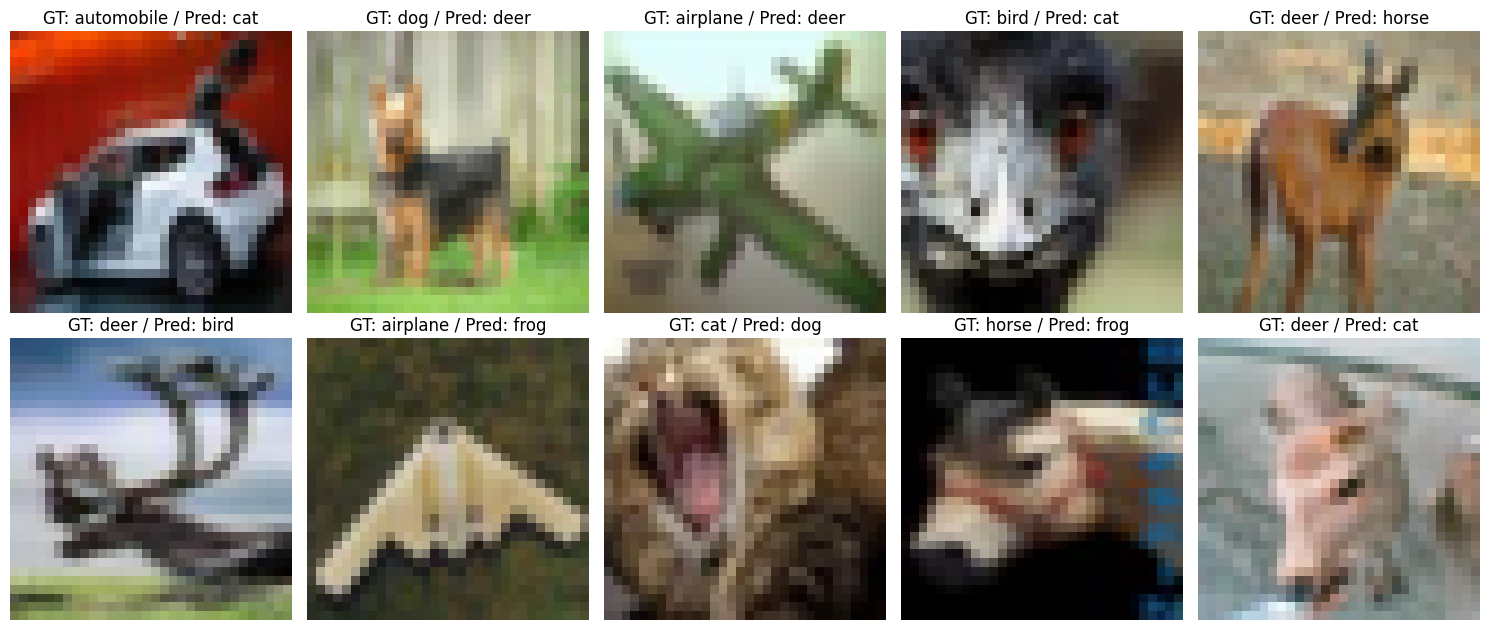

In [15]:
# 오분류(실패) 샘플만 시각화
def plot_misclassified_samples(model, data_loader, max_samples: int = 10):
    """테스트 데이터에서 오분류된 샘플만 골라 시각화합니다.

    Args:
        model: 학습된 분류 모델
        data_loader: (data, target)을 내는 DataLoader
        max_samples: 최대 출력 샘플 수 (기본 10)
    """
    model.eval()
    mis_images, mis_labels, mis_preds = [], [], []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)

            logits = model(data)                 # [B, num_classes] 로짓
            preds = logits.argmax(dim=1)         # 각 샘플의 예측 클래스

            wrong_mask = preds.ne(target)        # 오분류 위치만 True
            if wrong_mask.any():
                # 오분류된 샘플만 추출
                wrong_data = data[wrong_mask].detach().cpu()  # keep as Tensor for denormalize
                wrong_target = target[wrong_mask].detach().cpu()
                wrong_preds = preds[wrong_mask].detach().cpu()

                for x, y, p in zip(wrong_data, wrong_target, wrong_preds):
                    mis_images.append(x)
                    mis_labels.append(int(y))
                    mis_preds.append(int(p))
                    if len(mis_images) >= max_samples:
                        break

            if len(mis_images) >= max_samples:
                break

    if len(mis_images) == 0:
        print("오분류 샘플이 없습니다. (현재 설정/에폭에서 테스트를 모두 맞췄을 가능성이 있습니다)")
        return

    # 시각화 그리드: 최대 10개를 2×5로 보기 좋게 배치
    n = min(len(mis_images), max_samples)
    rows = 2 if n > 5 else 1
    cols = 5 if n > 5 else n

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3.2*rows))
    axes = np.array(axes).reshape(-1)  # axes를 1D로 평탄화

    for i in range(rows * cols):
        ax = axes[i]
        if i < n:
            img_chw = mis_images[i]  # CIFAR-10: (3,32,32)
            img_vis = denormalize_cifar10(img_chw).detach().cpu().numpy().transpose(1, 2, 0)  # HWC
            ax.imshow(img_vis)
            ax.set_title(f"GT: {class_names[mis_labels[i]]} / Pred: {class_names[mis_preds[i]]}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# 실행: 오분류 샘플만 출력
plot_misclassified_samples(model, test_loader, max_samples=10)


---
## 9) (추가 실습) ONNX Export + Netron으로 구조 확인하기

- **목적:** ViT를 ONNX로 내보내고, Netron에서 *토큰화(패치 임베딩) → Transformer 블록 → Head* 흐름을 그래프로 확인합니다.
- **관찰 포인트:**
  - `print(model)` / `torchinfo.summary(...)`에서 본 레이어가 Netron 그래프에서 어떻게 연결되는지
  - 입력 텐서 크기(예: `[B, 3, 32, 32]`)가 중간에서 토큰 시퀀스(`[B, N, D]`)로 변환되는 지점이 어디인지


In [16]:
# 필요 패키지 확인 (이미 ensure_package가 있다면 그걸 써도 됩니다)
# - onnx / onnxruntime는 환경에 따라 없을 수 있으니, 없으면 설치하세요.
# ensure_package("onnx")
# ensure_package("onnxruntime")

import torch

onnx_path = "vit_cifar10.onnx"
dummy = torch.randn(1, 3, 32, 32, device=device)  # CIFAR-10 입력 형식 (RGB, 32x32)
model.eval()

try:
    torch.onnx.export(
        model,
        dummy,
        onnx_path,
        input_names=["input"],
        output_names=["logits"],
        opset_version=17,
        do_constant_folding=True,
        dynamic_axes={"input": {0: "B"}, "logits": {0: "B"}},  # 배치 크기만 가변 처리
    )
    print("Saved ONNX:", onnx_path)
    print("Netron에서 열어서 (patch embedding → transformer blocks → head) 흐름을 확인해보세요.")
except Exception as e:
    print("ONNX export failed:", e)
    print("힌트: onnx 패키지가 없다면 `pip install onnx`가 필요할 수 있습니다.")


Saved ONNX: vit_cifar10.onnx
Netron에서 열어서 (patch embedding → transformer blocks → head) 흐름을 확인해보세요.
